### 2018/2019 - Task List 7

[Book](https://raw.githubusercontent.com/jonesgithub/book-1/master/ML%20Machine%20Learning-A%20Probabilistic%20Perspective.pdf)
[Advanced pyro guide](http://pyro.ai/examples/bayesian_regression_ii.html)

0. Fix task list 5 to be a proper linear model (check fixed code in base repository)
1. Reimplement Task List 5 creating guide function manualy
    - create apropriate parameters (mean and std for a and b, sigma - noise)
    - create probabilistic mode using pyro API
    - compute y using sampled a,b
2. Visualize data and learned function (as on Task List 5)
3. Use `AutoMultivariateNormal` guide function
    - all parameters of guide are from normal distribution
    - covariance matrix is not diagonal
4. Visualize results of `AutoMultivariateNormal` vs `AutoDiagonalNormal`


## Required imports

In [3]:
%matplotlib inline
import pyro
import torch
import numpy as np
import matplotlib.pyplot as plt
import pyro.optim as optim
import pyro.distributions as dist
from torch.distributions import constraints
from tqdm import tqdm_notebook as tqdm
import seaborn as sns
from matplotlib import animation, rc
from IPython.display import HTML
import torch.nn as nn
from functools import partial
import pandas as pd
from pyro.contrib.autoguide import AutoDiagonalNormal, AutoMultivariateNormal
from pyro.infer import EmpiricalMarginal, SVI, Trace_ELBO, TracePredictive

In [4]:
pyro.set_rng_seed(1)
pyro.enable_validation(True)

## Solutions

In [5]:
def read_choosed_parameters_values():
    yeast_names = ('Sequence Name', 'mcg', 'gvh', 'alm', 'mit', 'erl', 'pox', 'vac', 'nuc', 'class')
    yeast_dtype = {yeast_names[0]: 'str', yeast_names[1]: 'float', yeast_names[2]: 'float', yeast_names[3]: 'float',
                yeast_names[4]: 'float', yeast_names[5]: 'float', yeast_names[6]: 'float', yeast_names[7]: 'float',
                 yeast_names[8]: 'float', yeast_names[9]: 'str'}

    # read data set from previous task list
    yeast_data = pd.read_csv('yeast.data', header = None,
                   names = yeast_names, dtype = yeast_dtype, sep = ' ')
    
    mcg_tensor = torch.tensor(yeast_data[yeast_names[1]].values).float()[:,None]
    gvh_tensor = torch.tensor(yeast_data[yeast_names[2]].values).float()[:,None]
    
#     mcg_tensor = yeast_data[yeast_names[1]].values[:,None]
#     gvh_tensor = yeast_data[yeast_names[2]].values[:,None]

    return mcg_tensor.squeeze(1), gvh_tensor.squeeze(1)

def visualize_result(posterior):
    trace_pred = TracePredictive(wrapped_model,
                                 posterior,
                                 num_samples=count)
    
    post_pred = trace_pred.run(mcg_data, None)
    post_summary = summary(post_pred, sites = ['prediction', 'obs'])
    mu = post_summary["prediction"]
    y = post_summary["obs"]
    predictions = pd.DataFrame({
        "x": mcg_data,
        "mu_mean": mu["mean"],
        "mu_perc_5": mu["5%"],
        "mu_perc_95": mu["95%"],
        "y_mean": y["mean"],
        "y_perc_5": y["5%"],
        "y_perc_95": y["95%"],
        "true_y": gvh_data,
    })

    predictions.sort_values('x', inplace=True)
    x_values = torch.FloatTensor(predictions['x'].values.tolist()).squeeze().numpy()

    # plot probabilities
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 6))
    plt.plot(x_values, gvh_data.squeeze().numpy(), "bo")
    plt.plot(x_values, predictions['mu_mean'], 'r');
    plt.fill_between(x_values,
                       predictions["mu_perc_5"],
                       predictions["mu_perc_95"],
                       color='r',
                       alpha=0.5);
    plt.show()

    # plot outcome variables
    # mcg_data, gvh_data
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 6))
    plt.plot(x_values, gvh_data.squeeze().numpy(), "bo")
    plt.plot(x_values, predictions['y_mean'], 'r');
    plt.fill_between(x_values,
                       predictions["y_perc_5"],
                       predictions["y_perc_95"],
                       color='r',
                       alpha=0.5);
    plt.show()

In [13]:
x, y = read_choosed_parameters_values()

In [17]:
y

tensor([0.6100, 0.6700, 0.6200,  ..., 0.5700, 0.4000, 0.5400])

In [6]:
class RegressionModel(nn.Module):
    def __init__(self):
        # p = number of features
        super(RegressionModel, self).__init__()
        self.a = nn.Linear(1, 1, bias=False)
        self.b = nn.Parameter(torch.tensor(1.))

    def forward(self, x):
        return self.a(x) + self.b

def create_probabilistic_model():
    regression_model=RegressionModel()
    def probabilistic_model(x_data, y_data):        
        a = pyro.sample("a", dist.Normal(8., 1000.))
        b_a = pyro.sample("bA", dist.Normal(0., 1.))
        sigma = pyro.sample("sigma", dist.Uniform(0., 10.))
        mean = a * x_data + b_a
        
#         with pyro.iarange('data_loop', len(x_data)):
        with pyro.plate("map", len(x_data)):
            pyro.sample("obs", dist.Normal(mean, sigma), obs=y_data)
            return mean
    return probabilistic_model

def guide(x_data, y_data):
    a_loc = pyro.param('w_loc', torch.tensor(0.))
    a_scale = pyro.param('w_scale', torch.tensor(1.),
                        constraint=constraints.positive)
    b_loc = pyro.param('b_loc', torch.tensor(0.))
    b_scale = pyro.param('b_scale', torch.tensor(1.),
                        constraint=constraints.positive)  
    sigma_loc = pyro.param('sigma_loc', torch.tensor(1.),
                             constraint=constraints.positive)
    
    a = pyro.sample("a", dist.Normal(a_loc, a_scale))
    b_a = pyro.sample("bA", dist.Normal(b_loc, b_scale))
    sigma = pyro.sample("sigma", dist.Normal(sigma_loc, torch.tensor(0.05)))
    mean = a * x_data + b_a

# why not passing x_data, y_data ?
def train():
    pyro.clear_param_store()
    num_iterations = 3000 #8000
    model = create_probabilistic_model()
#     guide = AutoDiagonalNormal(model)
    optim = pyro.optim.Adam({"lr": 0.005})
    svi = pyro.infer.SVI(model, guide, optim, loss=pyro.infer.Trace_ELBO(), num_samples=count)
    t=tqdm(range(num_iterations))
    for j in t:
        # mcg_data, gvh_data
        loss = svi.step(mcg_data, gvh_data)
        t.set_postfix(loss=loss)
    return (model, svi)

def get_marginal(traces, sites):
    empirical_marginal=EmpiricalMarginal(traces, sites)
    return empirical_marginal._get_samples_and_weights()[0].detach().cpu().numpy()

def summary(traces, sites):
    marginal = get_marginal(traces, sites)
    site_stats = {}
    for i in range(marginal.shape[1]):
        site_name = sites[i]
        site_marginal=marginal[:, i]
        marginal_site = pd.DataFrame(site_marginal).transpose()
        describe = partial(pd.Series.describe, percentiles=[.05, 0.25, 0.5, 0.75, 0.95])
        site_stats[site_name] = marginal_site.apply(describe, axis=1) \
            [["mean", "std", "5%", "25%", "50%", "75%", "95%"]]
    return site_stats

def wrapped_model(x_data, y_data):
    model_result=probabilistic_model(x_data, y_data)
    pyro.sample("prediction", pyro.distributions.Delta(model_result))

mcg_data, gvh_data = read_choosed_parameters_values()
count = len(mcg_data)
print(count)

1484



Check parameters:
w_loc tensor(0.5076, requires_grad=True)
w_scale tensor(0.0370, grad_fn=<AddBackward0>)
b_loc tensor(0.2421, requires_grad=True)
b_scale tensor(0.0240, grad_fn=<AddBackward0>)
sigma_loc tensor(0.1945, grad_fn=<AddBackward0>)


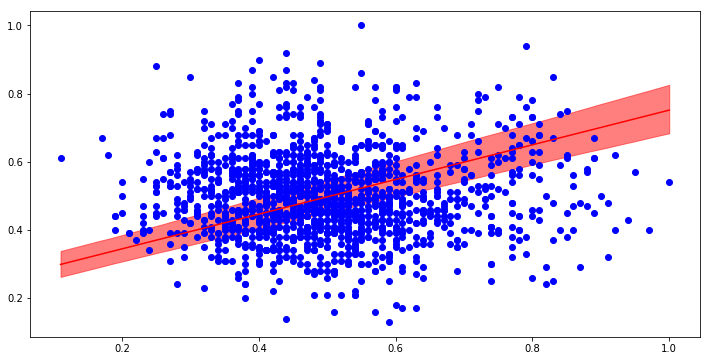

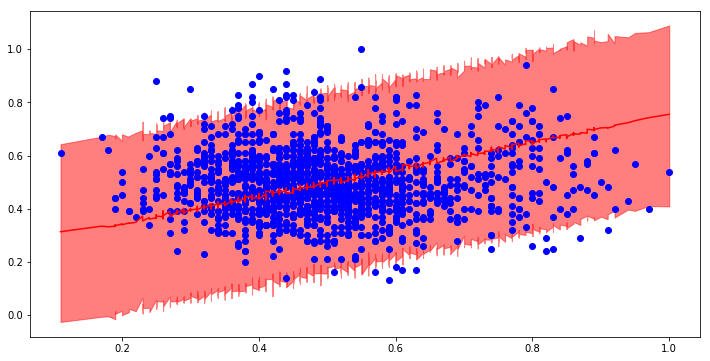

In [18]:
# x_data, y_data = mcg_data, gvh_data
# tensor(0.5001)
computed_mean_mcg = mcg_data.mean()
# tensor(0.1373)
computed_std_mcg = mcg_data.std()
# tensor(0.4999)
computed_mean_gvh = gvh_data.mean()
# tensor(0.1239)
computed_std_gvh = gvh_data.std()

probabilistic_model, svi = train()

# check parameters
print("Check parameters:")
for name, value in pyro.get_param_store().items():
    print(name, pyro.param(name))

# evaluation
# x_data, y_data
posterior = svi.run(mcg_data, gvh_data)
visualize_result(posterior)


3. Use `AutoMultivariateNormal` guide function
    - all parameters of guide are from normal distribution
    - covariance matrix is not diagonal

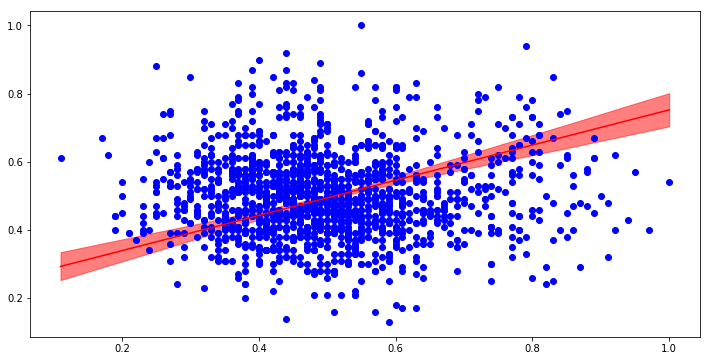

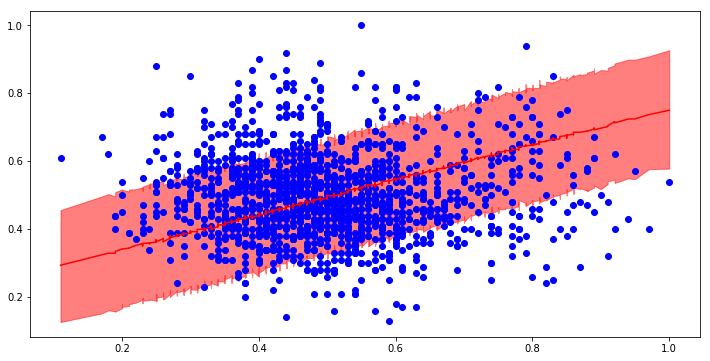

In [8]:
def train_with_guide(guide, steps, learning_rate):
    pyro.clear_param_store()
    num_iterations = steps #8000
    model = create_probabilistic_model()
    guide = guide(model)
    optim = pyro.optim.Adam({"lr": learning_rate})
    svi = pyro.infer.SVI(model, guide, optim, loss=pyro.infer.Trace_ELBO(), num_samples=count)
    t=tqdm(range(num_iterations))
    for j in t:
        loss = svi.step(mcg_data, gvh_data)
        t.set_postfix(loss=loss)
    return (model, svi)

probabilistic_model_multi_normal, svi_multi_normal = train_with_guide(AutoMultivariateNormal, 3000, 0.05)

posterior_multi_normal = svi_multi_normal.run(mcg_data, gvh_data)
visualize_result(posterior_multi_normal)

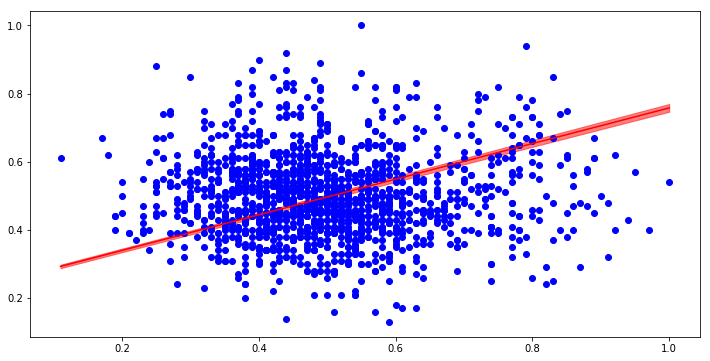

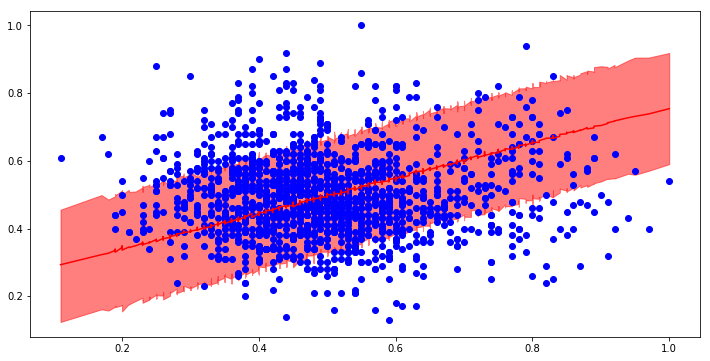

In [9]:
probabilistic_model_normal, svi_normal = train_with_guide(AutoDiagonalNormal, 3000, 0.05)
posterior_normal = svi_normal.run(mcg_data, gvh_data)
visualize_result(posterior_normal)

4. Visualize results of `AutoMultivariateNormal` vs `AutoDiagonalNormal`

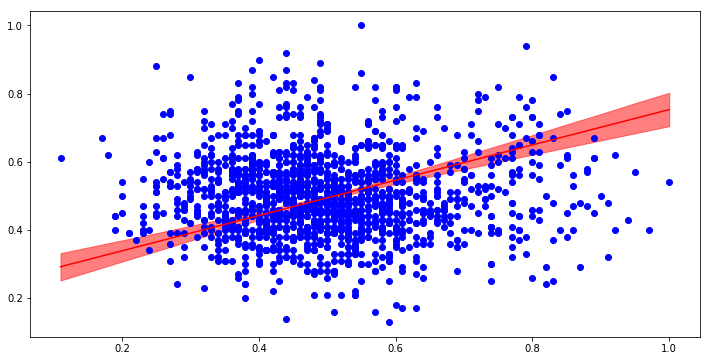

In [10]:
trace_pred_multi_normal = TracePredictive(wrapped_model,
                             posterior_multi_normal,
                             num_samples=count)
trace_pred_normal = TracePredictive(wrapped_model,
                             posterior_normal,
                             num_samples=count)

post_pred = trace_pred_multi_normal.run(mcg_data, None)
post_summary = summary(post_pred, sites = ['prediction', 'obs'])
mu = post_summary["prediction"]
y = post_summary["obs"]
predictions = pd.DataFrame({
    "x": mcg_data,
    "mu_mean": mu["mean"],
    "mu_perc_5": mu["5%"],
    "mu_perc_95": mu["95%"],
    "y_mean": y["mean"],
    "y_perc_5": y["5%"],
    "y_perc_95": y["95%"],
    "true_y": gvh_data,
})

predictions.sort_values('x', inplace=True)
x_values = torch.FloatTensor(predictions['x'].values.tolist()).squeeze().numpy()

# plot probabilities
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 6))
plt.plot(x_values, gvh_data.squeeze().numpy(), "bo")
plt.plot(x_values, predictions['mu_mean'], 'r');
plt.fill_between(x_values,
                   predictions["mu_perc_5"],
                   predictions["mu_perc_95"],
                   color='r',
                   alpha=0.5);

# AutoDiagonalNormal
# post_pred = trace_pred_normal.run(mcg_data, None)
# post_summary = summary(post_pred, sites = ['prediction', 'obs'])
# mu = post_summary["prediction"]
# y = post_summary["obs"]
# predictions = pd.DataFrame({
#     "x": mcg_data,
#     "mu_mean": mu["mean"],
#     "mu_perc_5": mu["5%"],
#     "mu_perc_95": mu["95%"],
#     "y_mean": y["mean"],
#     "y_perc_5": y["5%"],
#     "y_perc_95": y["95%"],
#     "true_y": gvh_data,
# })

# plt.plot(x_values, predictions['mu_mean'], 'g');
# plt.fill_between(x_values,
#                    predictions["mu_perc_5"],
#                    predictions["mu_perc_95"],
#                    color='g',
#                    alpha=0.5);
plt.show()

# # plot outcome variables
# fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 6))
# plt.plot(x_values, gvh_data.squeeze().numpy(), "bo")
# plt.plot(x_values, predictions['y_mean'], 'r');
# plt.fill_between(x_values,
#                    predictions["y_perc_5"],
#                    predictions["y_perc_95"],
#                    color='r',
#                    alpha=0.5);
# plt.show()

In [11]:
# mcg_data.squeeze().numpy()
# print(mcg_data.squeeze(-1))
mcg_data, gvh_data = read_choosed_parameters_values()
# print(mcg_data.squeeze(1))
torch.cat((torch.zeros(4732), torch.ones(2691)))

# print(len(mcg_data), len(mcg_data.squeeze(1)))


tensor([0., 0., 0.,  ..., 1., 1., 1.])

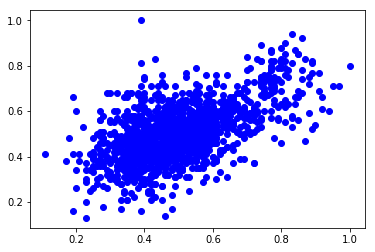

In [12]:
# fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 6))
# print(list(mcg_data), gvh_data)
plt.plot(list(mcg_data), list(gvh_data), "bo")
plt.show()